In [1]:
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import numpy as np
import ast

In [2]:
def read_image(img_path):
    img = Image.open(img_path)
    return np.array(img)

def get_pedestrian_box(txt_path):
    data = open(txt_path).readlines()
    bbox = []
    for d in data:
        d = d.rstrip()
        d = np.array(ast.literal_eval(d))
        
        x1, x2 = max(d[:, 0]), min(d[:, 0])
        y1, y2 = max(d[:, 1]), min(d[:, 1])
        
        bbox.append(([x1, y1, x2, y2], -1))
    return bbox

def get_vehicle_box(txt_path):
    data = open(txt_path).readlines()
    bbox = []
    for d in data:
        d, label = d.rstrip().split('\t')
        d = np.array(ast.literal_eval(d))
        
        x1, x2 = max(d[:, 0]), min(d[:, 0])
        y1, y2 = max(d[:, 1]), min(d[:, 1])
        
        bbox.append(([x1, y1, x2, y2], int(label)))
    return bbox

In [3]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = sorted(glob("custom_data/*.png"))
segimage_path = sorted(glob("SegmentationImage/*.png"))
ped_box_path = sorted(glob("PedestrianBBox/*"))
veh_box_path = sorted(glob("VehicleBBox/*"))


In [4]:
# img.shape

In [5]:
def remove_small_box(boxes, size_threshold, x_threshold = 0, y_threshold = 0):
    refine_box = []
    
    for box in boxes:
        bbox = box[0]
        xmin, xmax = min(bbox[0], bbox[2]), max(bbox[0], bbox[2])
        ymin, ymax = min(bbox[1], bbox[3]), max(bbox[1], bbox[3])
        
        x_size = xmax - xmin
        y_size = ymax-ymin
        
        if x_size > x_threshold and y_size > y_threshold and x_size * y_size > size_threshold:
            refine_box.append(box)
    return refine_box
    

In [6]:
a = np.array([1,2,3])
b = (a > 1) + (a < 3)
np.sum(b)

3

In [7]:
import copy
def remove_unseen_box(boxes, segmentation, label, threshold, margin = 0):
    refine_box = []
    r,g,b = label
    lim_y, lim_x = segmentation.shape[:2]
    
    for box in boxes:
        bbox = box[0]
        xmin, xmax = max(min(bbox[0], bbox[2], lim_x), 0), min(max(bbox[0], bbox[2], 0), lim_x)
        ymin, ymax = max(min(bbox[1], bbox[3], lim_y), 0), min(max(bbox[1], bbox[3], 0), lim_y)
        if xmin == xmax or ymin == ymax:
            continue

#         print(xmin, xmax, ymin, ymax, segmentation.shape)
        in_box_img = copy.deepcopy(segmentation[ymin:ymax + 1, xmin:xmax + 1, :])
#         print(in_box_img.shape)
        in_box_img[:, :, 0] = (r - margin <= in_box_img[:, :, 0]) * (in_box_img[:, :, 0] <= r + margin)
        in_box_img[:, :, 1] = (g - margin <= in_box_img[:, :, 1]) * (in_box_img[:, :, 1] <= g + margin)
        in_box_img[:, :, 2] = (b - margin <= in_box_img[:, :, 2]) * (in_box_img[:, :, 2] <= b + margin)
#         print(segmentation)
        correct = np.sum(in_box_img[:, :, 0] * in_box_img[:, :, 1] * in_box_img[:, :, 2])
        if correct / ((xmax+1 - xmin) * (ymax+1 - ymin)) > threshold:
            refine_box.append(box)
    return refine_box



In [8]:
# def remove_strange_box(boxes, img_size): #경계를 넘어가는 box제거
#     ymax, xmax = img_size
#     refine_box = []
#     for box in boxes:
#         bbox = box[0]
#         if bbox[0] < xmax and 0 < bbox[2] and bbox[1] < ymax and 0 < bbox[3]:
#             refine_box.append(box)
#     return refine_box



16


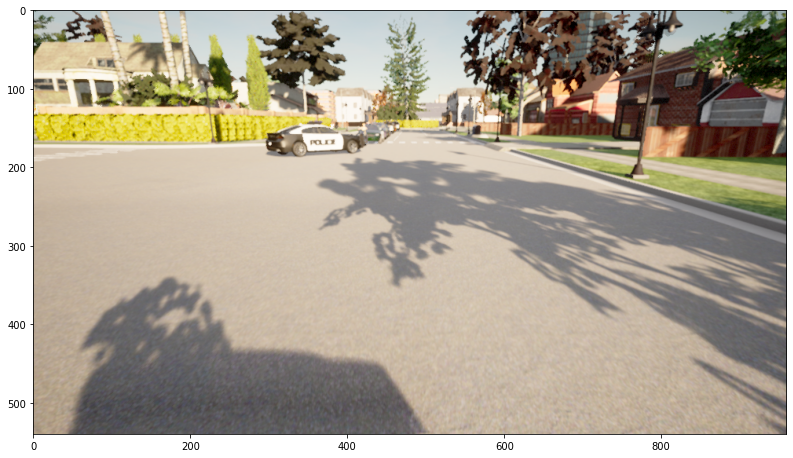

In [35]:
# boxs : box정보 + label정보
# bboxs: box정보만

# 사람 : (220, 020, 060)
# 차, 오토바이 : (000, 000, 142)
# 사람 : (220, 020, 060)
person = (220, 20, 60)
car = (0, 0, 142)

color_map = ['red', 'blue']
ped_color = ['black']

# image_path
# segimage_path

for i in range(len(veh_box_path)):
    i = 16
    print(i)
    plt.figure(figsize = (54/4, 96/4))
    img = read_image(segimage_path[i])

    boxs = get_pedestrian_box(ped_box_path[i])
#     boxs = remove_strange_box(boxs, img.shape[:2])
    boxs = remove_small_box(boxs, size_threshold = 30)
    boxs = remove_unseen_box(boxs, img, person, threshold = 0.10, margin = 10)
    print("person : ", boxs)
    for box in boxs:
        box, label = box
        plt.plot([box[0], box[0],box[2],box[2],box[0]], [box[1], box[3],box[3],box[1],box[1]], color = ped_color[0])

    boxs = get_vehicle_box(veh_box_path[i])
#     boxs = remove_strange_box(boxs, img.shape[:2])
    boxs = remove_small_box(boxs, size_threshold = 100)

    boxs = remove_unseen_box(boxs, img, car, threshold = 0.10, margin = 10)
    
    print("car : ", boxs)
    for box in boxs:
        box, label = box
        if label == 2:
            plt.plot([box[0], box[0],box[2],box[2],box[0]], [box[1], box[3],box[3],box[1],box[1]], color = color_map[0])
        else:
            plt.plot([box[0], box[0],box[2],box[2],box[0]], [box[1], box[3],box[3],box[1],box[1]], color = color_map[1])

    img = read_image(image_path[i])
    plt.imshow(img)

    plt.show()
    break